# Walkthrough downloading planet images

The following notebook incorporates tutorials on the Planet CLI from the following sources:
-  https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/data-api-tutorials/planet_python_client_introduction.ipynb
- https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/orders_api_tutorials/Planet_SDK_Orders_demo.ipynb

Please obtain your Planet API key from your Planet account before continuing.

In [1]:
from datetime import datetime
from planet import Auth
from planet import Session, DataClient, OrdersClient, data_filter
import json
import requests
import time
import os
import shutil
import cv2 as cv
import rasterio
from rasterio.windows import Window
from pyproj import Transformer
import numpy as np
import os
from os import listdir
from os.path import isfile, join
np.random.seed(42)

import copy
import matplotlib
import matplotlib.pyplot as plt


import pyproj
import pickle as pkl
import geojson
import cv2
from PIL import Image, ImageEnhance# We will also create a small helper function to print out JSON with proper indentation.
def indent(data):
    print(json.dumps(data, indent=2))

# *
The following code block requires ONE place to enter your API, on the bottom line paste your API where it says `PASTE API KEY HERE`.

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
if os.environ.get('PL_API_KEY', ''):
    API_KEY = os.environ.get('PL_API_KEY', '')
else:
    API_KEY = 'PASTE_YOUR_API_KEY_HERE'

client = Auth.from_key(API_KEY)

# Setup the session
session = requests.Session()

# Authenticate
session.auth = (API_KEY, "1c61ae19230448e19b5bc359cbf1232e")

# *
The following code block requires the file path to your geojson file, enter the file path and name of your region of interest.

In [3]:
with open("../Downloads/quebec.geojson") as f:
    geom = json.loads(f.read())

# *
The following code block is customizable.
- `geom_filter`: your geojson region of interset defined above.
- `clear_percent_filter`: percentage of clearness in each images
- `date_range_filter`: time period of study (`gt`: greater than, `lt`: less than)
- `cloud_cover_filter`: filter out clouds

In [4]:
item_types = ["PSScene"]

geom_filter = data_filter.geometry_filter(geom)
clear_percent_filter = data_filter.range_filter('clear_percent', 90)
date_range_filter = data_filter.date_range_filter("acquired", gt = datetime(month=4, day=30, year=2023), lt = datetime(month=8, day=30, year=2023))
cloud_cover_filter = data_filter.range_filter('cloud_cover', None, 0.25)

combined_filter = data_filter.and_filter([geom_filter, clear_percent_filter, cloud_cover_filter, date_range_filter])

In [5]:
async with Session() as sess:
    cl = DataClient(sess)
    request = await cl.create_search(name='planet_client_demo',search_filter=combined_filter, item_types=item_types)

# Search the Data API
# The limit paramter allows us to limit the number of results from our search that are returned.
# The default limit is 100. Here, we're setting our limit to the max of 500

In [6]:
async with Session() as sess:
    cl = DataClient(sess)
    items =  cl.run_search(search_id=request['id'], limit=2000) 
    item_list = [i async for i in items]
    

Following block prints all images to be downloaded. (all images that match your filters and contain any match of coordinates in your provided geojson.

In [7]:
# items = []
# for item in item_list:
# #     print(item['id'], item['properties']['item_type'])
#     items.append(item['id'])
# print(len(items))

In [8]:
# item_list[1]

In [9]:
items = []
unique_dates = set()

for item in item_list:
    item_id = item['id']
    date = item_id.split('_')[0]  # Extract the date part from the item_id
    if date not in unique_dates:
        unique_dates.add(date)
        items.append(item_id)

# Now, 'items' is a list containing one item['id'] for each unique date
print(len(items))


54


In [11]:
for i in items:
    print(i)

20230828_155412_59_2479
20230827_150608_20_24b5
20230829_150627_46_24c4
20230823_150328_63_2439
20230826_161537_97_2426
20230821_150359_14_24c3
20230824_150155_88_24ba
20230822_155115_33_2438
20230819_155710_16_227a
20230815_151448_53_2430
20230817_155439_78_2484
20230814_151139_66_2423
20230810_151830_92_24b5
20230816_154110_13_2477
20230806_145950_90_24b6
20230808_152206_76_24c9
20230809_155153_30_2478
20230805_151522_57_24ce
20230804_150309_66_2447
20230802_150712_56_2415
20230801_152030_35_24ba
20230727_151329_83_24b3
20230725_150421_84_2447
20230724_150116_28_2451
20230723_150442_81_24b0
20230722_154653_40_247b
20230721_151548_95_2465
20230717_151152_18_241d
20230714_150848_58_24a9
20230711_151748_12_242e
20230710_151800_91_24b3
20230707_150657_26_2451
20230705_155424_82_248e
20230704_151949_03_24ba
20230703_151427_85_24a7
20230629_151509_22_24c7
20230624_152208_70_24b0
20230619_151034_29_2415
20230622_151223_88_24cc
20230623_150612_46_2459
20230621_152209_34_24b6
20230620_151141_

In [20]:
#creates json for order
with open('results.json','w') as f:
    jsonStr = json.dumps(item_list)
    f.write(jsonStr)
    f.close()

Following code requires your API key again .

In [21]:
#order details
from getpass import getpass
from planet import Auth
api_key = getpass('Enter your API key:')

auth = Auth.from_key(api_key)

Enter your API key:········


In [22]:
from planet import order_request

item_ids = items

products = [
    order_request.product(item_ids, 'analytic_udm2', 'PSScene')
]

tools = [
    order_request.reproject_tool(projection='EPSG:4326', kernel='cubic')
]

request = order_request.build_request(
    '1', products=products, tools=tools)

# create order
Log in to planet at planet.com and check status of download.

**Note: this block appears to run indefinitely. By checking the status on your browser at planet.com, you will see when it has completed, and you can then stop this block and continue on. You can also check the directory in which this jupyter notebook is in and you will see a new folder with an obscure name consisting of numbers and characters.

In [23]:
from planet import reporting, Session, OrdersClient

# remember: "async def" to create the async coroutine
async def create_poll_and_download():
    async with Session(auth=auth) as sess:
        cl = OrdersClient(sess)

        # Use "reporting" to manage polling for order status
        with reporting.StateBar(state='creating') as bar:
            # create order via Orders client
            order = await cl.create_order(request)
            bar.update(state='created', order_id=order['id'])

            # poll...poll...poll...
            await cl.wait(order['id'], callback=bar.update_state)

        # if we get here that means the order completed. Yay! Download the files.
        await cl.download_order(order['id'])

# remember: "await" to run the thing
await create_poll_and_download()

13:21 - order e8b4cf93-fc57-44e4-b23d-f2741019ef7a - state: success


OSError: [Errno 28] No space left on device

# Preprocess Planet Data Download
enter the name of the directory automatically downloaded via planet. Creates directory from planet downloaded directory in which we will move all applicable satellite images.


In [14]:
import os
folder_dir= 'wf1'
img_dir = 'imgdir'
final = os.path.join(folder_dir, img_dir)
os.mkdir(final)

In [15]:

#Moving all .tif files into a separate image directory (defined above) for ease of handling.
main_dir = 'wf1/15661313-279a-4517-a02b-9adcecd3c048/PSScene'
for file in os.listdir(folder_dir):
    if file.endswith('.tif'):
        shutil.move(os.path.join(folder_dir, file), final)

### Optional file rename function. Play around with it before running it. 
Sometimes Planet inputs an extra `1` charachter in the name, and the function below removes that `1`.

In [28]:
def planet_file_rename(main_directory, name_change = False):
    
    for f in sorted(listdir(main_directory)):
        if f.endswith(".tif"):
#             print(f)
        # extract the spot in the file name that has these extra charchters
            name = f.split('_')[2]
#             print(f)
#here is where we rename the files. These charachters are never more than 3 charchters thus,
            if len(name) < 4:
#                 print(f[:16] + f[16+len(name)+1:])
#                 print(name)
#                 ##renaming the file without the extra charchters (using the len function)
                g = f[:16] + f[16+len(name)+1:]
#                 print(g)
                ###MAKE SURE YOU HAVE A COPY OF YOUR DIRECTORY BEFORE RUNNING THIS LINE!!
                if name_change == True:
                    os.rename(os.path.join(main_directory, f), os.path.join(main_directory, g))
        print('name change implemented')
                    
planet_file_rename(final, name_change= True)

name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change implemented
name change impl

`image_cropping`: This function reshapes the larger raster geoTIFF images downloaded from planet into a 224x224 numpy array image, stored in a separate `crop` folder created. I recommened making a copy of the final `crop` folder and deleting the large raster images as they take up a lot of space. The `black_space` call filters out images that are either over saturated with clouds or do not have a complete capture of our area of interest, as these will not help with our analysis.
- `main_directory` is the full path to the images downloaded. 
- `cropped_img_folder_name` is the name of the folder in which you will store your cropped images.
- `lat` is the latitude of your area of interest.
- `lon` is the longitude of your area of interest.
- `x` is the length which you wish to crop your images
- `y` is the height in which you wish to crop your images.

There is a lot of flexibility to play around with this function before committing to cropping. I'd recommend familiarizing yourself with it prior to running.

In [78]:
import numpy as np

# Define the coordinates of the bounding box
coordinates = [[-77.25904388340517, 49.697665323961985],
               [-77.25904388340517, 48.235897255742344],
               [-75.19550869763293, 48.235897255742344],
               [-75.19550869763293, 49.697665323961985]]

# Calculate the center of the bounding box
latitudes = [coord[1] for coord in coordinates]
longitudes = [coord[0] for coord in coordinates]

center_latitude = np.mean(latitudes)
center_longitude = np.mean(longitudes)

print("Center Latitude:", center_latitude)
print("Center Longitude:", center_longitude)


Center Latitude: 48.966781289852165
Center Longitude: -76.22727629051906


In [23]:
working_path = 'batch1/5aaebcf1-7ddb-42c6-b6f2-4c6f4b81b224/PSScene/'
# import rasterio
# import matplotlib.pyplot as plt

# # Open the 4-band image (with an IR band)
# with rasterio.open(working_path) as src:
#     # Read the individual bands
#     red = src.read(1)
#     green = src.read(2)
#     blue = src.read(3)
#     infrared = src.read(4)

#     # Create a true-color image by rearranging the bands
#     true_color_image = [red, green, blue, infrared]

#     # Normalize the image to 8-bit (0-255) for display
#     for i in range(4):
#         true_color_image[i] = ((true_color_image[i] - true_color_image[i].min()) /
#                                (true_color_image[i].max() - true_color_image[i].min()) * 255).astype('uint8')

#     # Stack the bands into a single RGB image
#     rgb_image = rasterio.plot.reshape_as_image(true_color_image)

#     # Display the RGB image
#     plt.imshow(rgb_image)
#     plt.axis('off')
#     plt.show()



In [16]:
with rasterio.open(working_path) as src:
    # Access the coordinate reference system (CRS) information
    crs = src.crs

print("Coordinate System (CRS):", crs)



Coordinate System (CRS): EPSG:32618


In [72]:
def image_cropping(main_directory, cropped_img_folder_name, lat, lon, x, y):
    #make directory for newly cropped images
    PROJECT_ROOT_DIR = main_directory
    PROJECT_SAVE_DIR = cropped_img_folder_name
    
    if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
        print('Figure directory didn''t exist, creating now.')
        os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
    else:
        print('Figure directory exists.') 
        
    new_dir = PROJECT_ROOT_DIR+'/'+ PROJECT_SAVE_DIR

    for f in sorted(listdir(main_directory)):
        if f.endswith(".tif"):
            print(f)
            working_path = os.path.join(main_directory, f)
            with rasterio.open(working_path) as rds:
                transformer = Transformer.from_crs("EPSG:4326", rds.crs, always_xy=True)
                xx, yy = transformer.transform(lon, lat)
                row, col = rds.index(xx, yy)
                print(row, col)
                if row > x and col > y:
                    try:
                        window = Window.from_slices(rows = (row-x, row+x), cols =(col-y, col+y))
                        data = rds.read(window=window)
                        data = np.moveaxis(data, 0, 2)    #Move axes of an array to new positions

                        img_arr = np.array(data)
                        black_space = np.mean(img_arr[:,:,:]/255)
                        
                        #`black_space` as in incomplete images or cut off images
                        
                        if black_space > 0.5 and black_space <0.9:
                            print(black_space)
                            plt.imshow(data)
                            plt.axis('off')
                            plt.show()
                            im = Image.fromarray(data)
                            im.save(main_directory+'/'+cropped_img_folder_name+'/'+str(f))  
                    except Exception as e:
                        print(e)
                        pass
                else: pass
                        
                if row < x or col <y:
                    print('invalid row or col length: ',row, col)
                    pass   

Figure directory exists.
20201117_055813_240f_3B_Visual_reproject.tif
7218 7510
20201204_055929_241c_3B_Visual_reproject.tif
1706 8511
20210222_051509_2264_3B_Visual_reproject.tif
4863 6859
20210222_055654_240a_3B_Visual_reproject.tif
5860 2294
0.7784441540287992


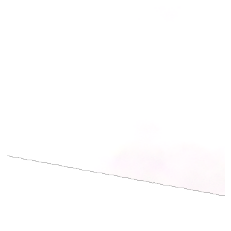

20210305_055407_240f_3B_Visual_reproject.tif
2585 14349
20210418_055327_240c_3B_Visual_reproject.tif
2572 10232
0.8073101064644608


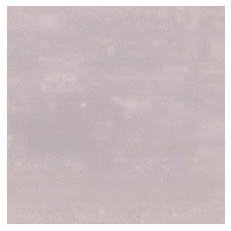

20210506_050729_2427_3B_Visual_reproject.tif
2609 10524
0.7976372070312499


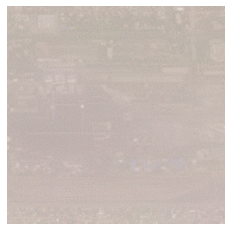

20210510_050244_2445_3B_Visual_reproject.tif
3529 14649
20210514_055134_240c_3B_Visual_reproject.tif
5638 134
invalid row or col length:  5638 134
20210530_055500_2307_3B_Visual_reproject.tif
6765 7077
0.752486079197304


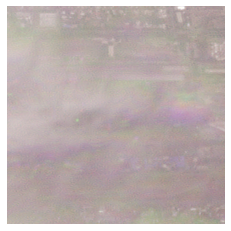

20210608_050754_222b_3B_Visual_reproject.tif
4942 10777
20210611_050320_2427_3B_Visual_reproject.tif
2529 10741
0.7921414483762255


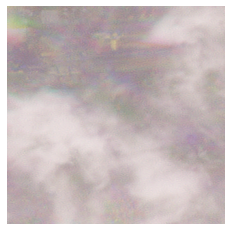

20210620_050123_2427_3B_Visual_reproject.tif
2335 614
20210711_055301_2413_3B_Visual_reproject.tif
6210 7431
0.8609249578737744


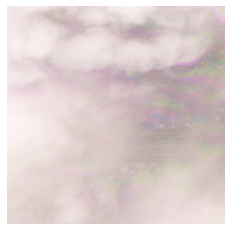

20210803_051005_2262_3B_Visual_reproject.tif
5684 2536
20211115_050048_242a_3B_Visual_reproject.tif
4240 1688
20211115_054629_2416_3B_Visual_reproject.tif
4650 13270
20211117_050046_2428_3B_Visual_reproject.tif
4948 6149
20211203_054807_2274_3B_Visual_reproject.tif
2776 8088
20211205_055008_2402_3B_Visual_reproject.tif
2741 5038
20211208_055119_2426_3B_Visual_reproject.tif
3406 8078
0.7476453546262255


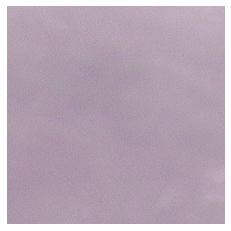

20211215_051540_2233_3B_Visual_reproject.tif
6717 12590
20211215_051542_2233_3B_Visual_reproject.tif
2564 13802
20211225_054417_2307_3B_Visual_reproject.tif
1648 6545
20211227_055057_2406_3B_Visual_reproject.tif
3372 884
20220110_051241_2276_3B_Visual_reproject.tif
5220 37
invalid row or col length:  5220 37
20220110_051244_2276_3B_Visual_reproject.tif
1009 1315
20220115_045947_2423_3B_Visual_reproject.tif
2744 1443
20220119_054658_227a_3B_Visual_reproject.tif
4226 7942
20220120_050336_2235_3B_Visual_reproject.tif
2790 2811
20220123_045955_2458_3B_Visual_reproject.tif
4840 9354
20220203_045621_241d_3B_Visual_reproject.tif
4278 884
20220208_054244_2424_3B_Visual_reproject.tif
6318 2454
20220208_054246_2424_3B_Visual_reproject.tif
2083 3717
20220215_045903_242b_3B_Visual_reproject.tif
7603 13021
20220215_045905_242b_3B_Visual_reproject.tif


/Users/sarah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3291 14166
20220215_050344_220b_3B_Visual_reproject.tif
2587 2959
20220216_045803_2430_3B_Visual_reproject.tif
3467 5989
20220216_055015_2413_3B_Visual_reproject.tif
5163 2247
20220216_055018_2413_3B_Visual_reproject.tif
924 3571
20220306_053007_249d_3B_Visual_reproject.tif
5089 9688
20220309_052701_2499_3B_Visual_reproject.tif
5499 5727
20220317_053108_247d_3B_Visual_reproject.tif
1865 1701
20220406_050239_2223_3B_Visual_reproject.tif
3624 1284
0.5499929438572305


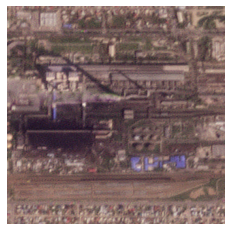

20220407_045732_241a_3B_Visual_reproject.tif
5910 4491
0.6339662607230392


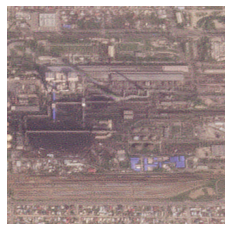

20220407_045735_241a_3B_Visual_reproject.tif
1710 5786
0.6336100739123774


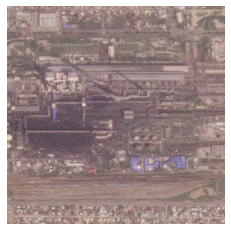

20220419_045646_2431_3B_Visual_reproject.tif
3277 3433
20220720_045122_2460_3B_Visual_reproject.tif
5501 6649
0.5716151290594362


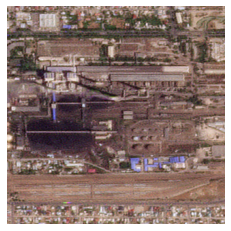

20220720_045124_2460_3B_Visual_reproject.tif
1296 7863
0.570961732153799


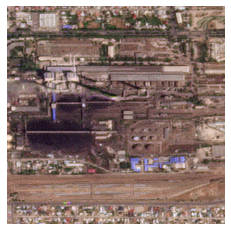

20220724_045531_2440_3B_Visual_reproject.tif
5131 873
0.7946572648590684


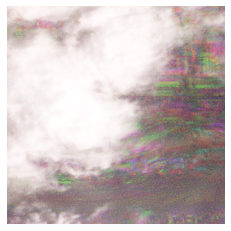

20220724_045534_2440_3B_Visual_reproject.tif
924 2165
0.7936829427083333


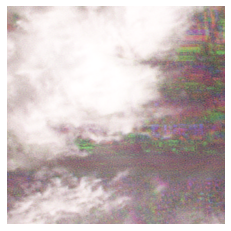

20220826_045515_242b_3B_Visual_reproject.tif
5815 10088
20220911_052924_2483_3B_Visual_reproject.tif
4934 2727
20220911_052926_2483_3B_Visual_reproject.tif
671 4046
20221027_045011_2451_3B_Visual_reproject.tif
5048 11686
20221031_045614_2427_3B_Visual_reproject.tif
5032 5886
20221031_053740_227a_3B_Visual_reproject.tif
5558 2755
0.7265162090226716


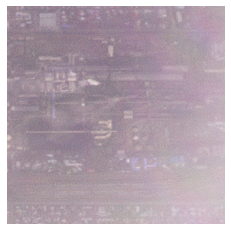

20221031_053742_227a_3B_Visual_reproject.tif
1175 4131
0.7262487266390931


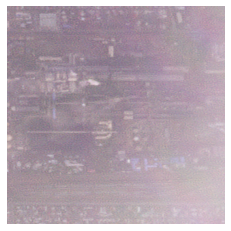

20221102_045419_241d_3B_Visual_reproject.tif
3630 11574
20221106_052651_247b_3B_Visual_reproject.tif
5169 3708
0.800248228783701


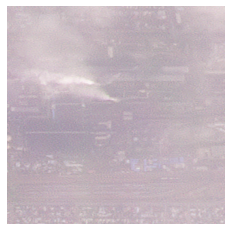

20221107_053844_2424_3B_Visual_reproject.tif
1902 3635
20221109_044855_2447_3B_Visual_reproject.tif
1040 1115
20221109_045535_2442_3B_Visual_reproject.tif
4503 10090
20221111_045312_2460_3B_Visual_reproject.tif
1551 4509
0.7008775850183824


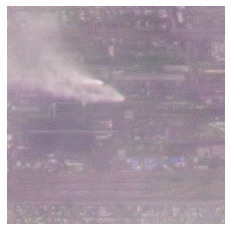

20221111_052649_247c_3B_Visual_reproject.tif
3286 8416
20221111_053157_2438_3B_Visual_reproject.tif
7447 12987
20221111_053159_2438_3B_Visual_reproject.tif
3137 14385
20221114_045042_2436_3B_Visual_reproject.tif
5191 4765
0.5452478362438726


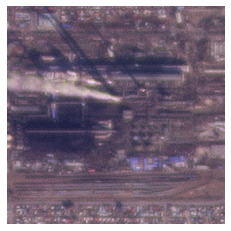

20221115_052812_248f_3B_Visual_reproject.tif
4049 12795
20221115_052958_2484_3B_Visual_reproject.tif
5372 5912
20221115_053000_2484_3B_Visual_reproject.tif
990 7354
0.6624609375


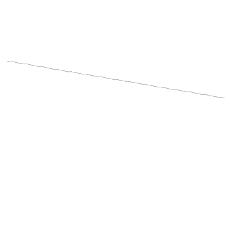

20221117_052706_2479_3B_Visual_reproject.tif
4500 7598
0.8227860274969362


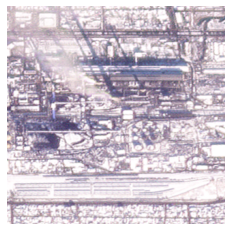

20221117_054151_240c_3B_Visual_reproject.tif
6036 3136
20221117_054153_240c_3B_Visual_reproject.tif
1875 4403
0.805327205882353


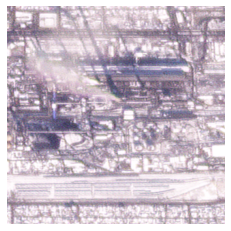

20221118_053120_2489_3B_Visual_reproject.tif
333 4121
20221121_045034_2449_3B_Visual_reproject.tif
2769 4525
20221121_045245_2421_3B_Visual_reproject.tif
1343 1548
20221121_053818_227b_3B_Visual_reproject.tif
4784 7310
20221126_052846_249c_3B_Visual_reproject.tif
5558 11855
20221126_053406_2424_3B_Visual_reproject.tif
1975 3210
20221127_052816_2498_3B_Visual_reproject.tif
1134 4209
0.8011836128982844


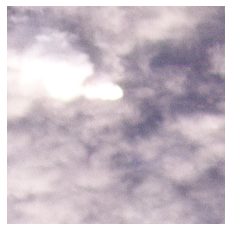

20221129_052537_24a4_3B_Visual_reproject.tif
5339 787
20221129_052539_24a4_3B_Visual_reproject.tif
960 2100
20221201_053808_227a_3B_Visual_reproject.tif
2805 6139
20221202_052632_2490_3B_Visual_reproject.tif
5730 1724
20221202_052634_2490_3B_Visual_reproject.tif
1392 3018
0.8166960114123774


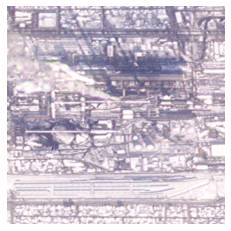

20221203_053222_2474_3B_Visual_reproject.tif
6999 10151
0.8069492091758579


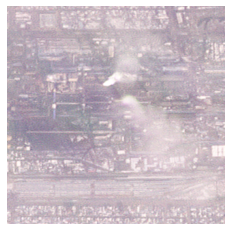

20221203_053225_2474_3B_Visual_reproject.tif
2663 11562
0.8068232038909313


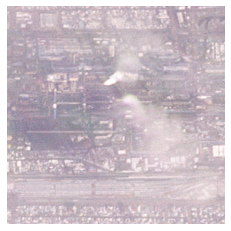

20221205_045238_2439_3B_Visual_reproject.tif
5979 2490
20221205_045240_2439_3B_Visual_reproject.tif
1641 3741
20221206_045010_2447_3B_Visual_reproject.tif
2312 3662
0.8691845798866421


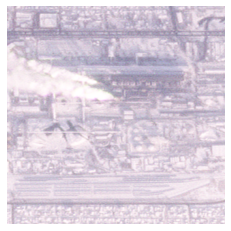

20221206_052910_24a5_3B_Visual_reproject.tif
4403 13483
20221207_045602_2421_3B_Visual_reproject.tif
3048 4594
0.8423244006587011


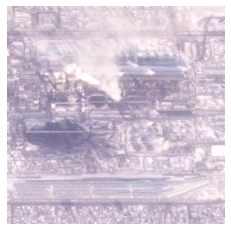

20221207_051444_225a_3B_Visual_reproject.tif
6841 10514
0.7849914407169117


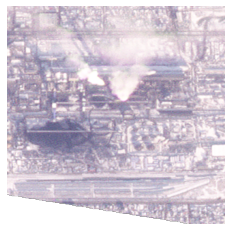

20221207_051446_225a_3B_Visual_reproject.tif
3052 11721
0.8315603841145832


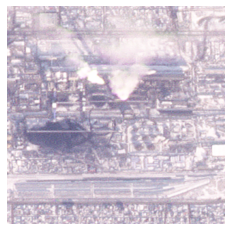

20221208_054232_240c_3B_Visual_reproject.tif
6881 10044
0.5880661956188725


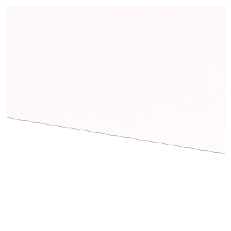

20221208_054234_240c_3B_Visual_reproject.tif
2716 11334
20221209_045206_2455_3B_Visual_reproject.tif
4642 13679
20221209_051607_2251_3B_Visual_reproject.tif
5686 4746
20221209_051609_2251_3B_Visual_reproject.tif
1895 5925
20221210_045432_241d_3B_Visual_reproject.tif
3896 8469
0.8664840686274511


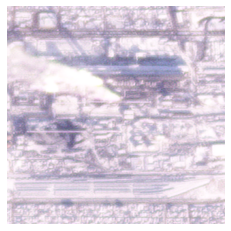

20221211_052724_2446_3B_Visual_reproject.tif
5109 2559
0.8343488625919118


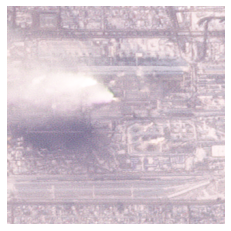

20221211_052726_2446_3B_Visual_reproject.tif
774 3835
0.8340785654105393


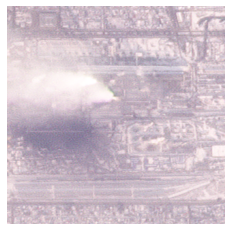

20221212_052946_2499_3B_Visual_reproject.tif
7566 11616
20221212_052948_2499_3B_Visual_reproject.tif
3614 12845
0.8269093232996322


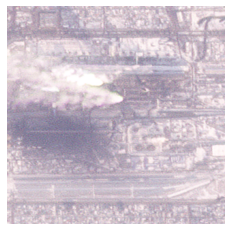

20221213_053134_2490_3B_Visual_reproject.tif
2756 7674
0.809559206495098


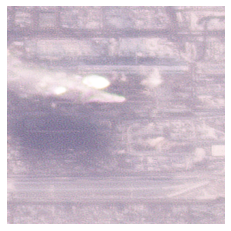

20221213_054635_2402_3B_Visual_reproject.tif
4479 5293
0.7891308785232843


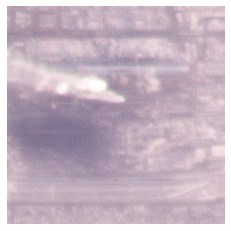

20221214_045302_2430_3B_Visual_reproject.tif
3628 11066
0.7457768363204658


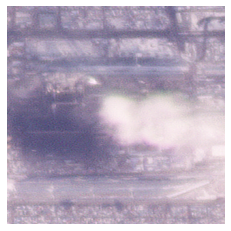

20221214_054748_2405_3B_Visual_reproject.tif
4224 9957
0.7544785634957109


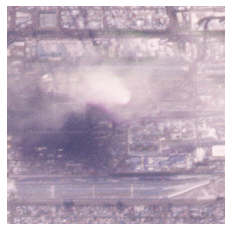

20221215_044858_2451_3B_Visual_reproject.tif
5839 5159
0.6751914732689951


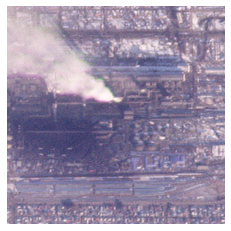

20221215_044901_2451_3B_Visual_reproject.tif
1537 6403
0.67455224609375


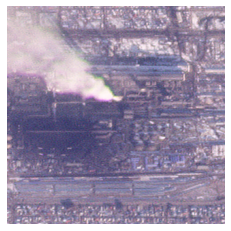

20221215_053057_2488_3B_Visual_reproject.tif
3649 9568
0.6555386891084559


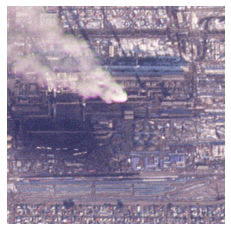

20221216_045419_2436_3B_Visual_reproject.tif
1826 5430
0.5620490483302697


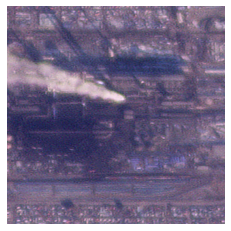

20221218_052730_249b_3B_Visual_reproject.tif
3867 6565
0.6448652152267158


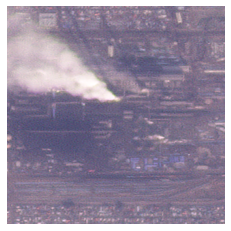

20221219_052640_2486_3B_Visual_reproject.tif
5627 3711
0.6651756472120098


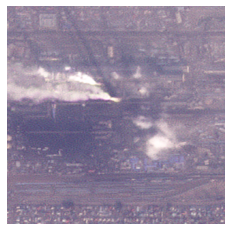

20221219_052642_2486_3B_Visual_reproject.tif
1290 4993
0.6648468137254904


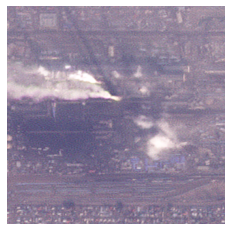

20221219_053153_248f_3B_Visual_reproject.tif
2798 6413
0.6670548981311272


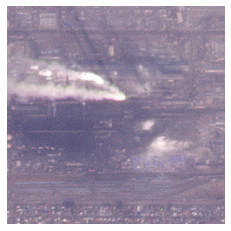

20221221_052610_247c_3B_Visual_reproject.tif
4801 1492
20221221_052612_247c_3B_Visual_reproject.tif
900 2688
20221221_053127_2438_3B_Visual_reproject.tif
4374 4255
20221221_053129_2438_3B_Visual_reproject.tif
441 5575
20221222_045430_241a_3B_Visual_reproject.tif
3264 6226
20221222_053842_241c_3B_Visual_reproject.tif
4507 3043
0.8860646733302697


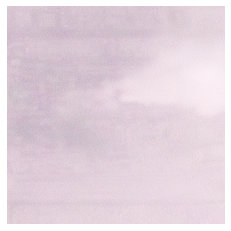

20221223_053035_247d_3B_Visual_reproject.tif
3925 11456
20221224_053053_249c_3B_Visual_reproject.tif
5691 4613
0.8292475202971814


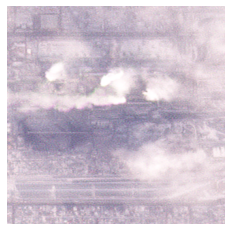

20221224_053055_249c_3B_Visual_reproject.tif
1491 5947
0.8286878159466912


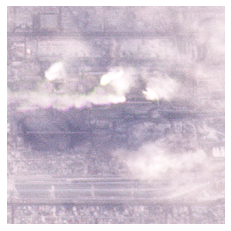

20221225_052713_2473_3B_Visual_reproject.tif
2711 8206
0.8416309838388483


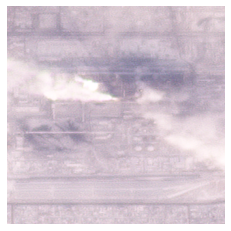

20221225_053139_2480_3B_Visual_reproject.tif
3304 10514
0.8587442746629904


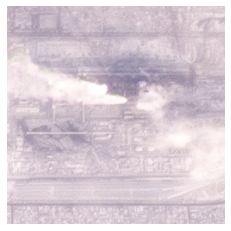

20221226_045533_2431_3B_Visual_reproject.tif
3354 8795
20221227_053939_227b_3B_Visual_reproject.tif
3904 11553
0.6992877987132353


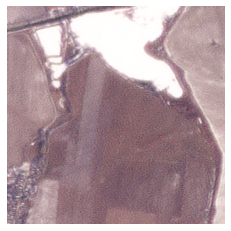

20221228_053153_247e_3B_Visual_reproject.tif
3554 10997
0.765973584941789


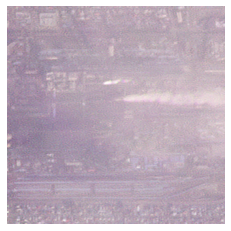

20221228_053652_241c_3B_Visual_reproject.tif
4740 2635
0.6565953871783088


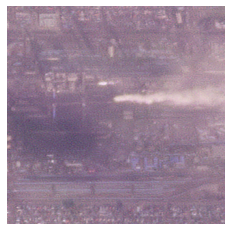

20221228_053655_241c_3B_Visual_reproject.tif
439 3943
20221230_052936_249e_3B_Visual_reproject.tif
5360 8568
20221231_045128_241f_3B_Visual_reproject.tif
4822 2534
20221231_045130_241f_3B_Visual_reproject.tif
549 3776
20221231_045344_241d_3B_Visual_reproject.tif
4047 2436
20221231_054551_2426_3B_Visual_reproject.tif
4304 11030


In [37]:
image_cropping(final, 'cropsbigger',42.871006,74.654881, x=160, y=160)
